In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.linear_model import LinearRegression

SEED = 12345678

In [2]:
df = pd.read_csv("life_expectancy.csv")
df = df.drop("Country", axis="columns")
df_train, df_test = train_test_split(df, random_state=SEED, test_size=0.25)

variables = list(df_train.columns.values)

LEB = "Life Expectancy at Birth, both sexes (years)"
HDE = "Human Development Index (value)"

Once we finished our setup, the first thing that we did was to find the pearson coefficients for every variable, so that we could find which was the strongest.

In [3]:
pearson = df_train.corr(method='pearson', min_periods=1, numeric_only=False)
pearson_drop = pearson[LEB].drop(LEB)
pearson_drop

Year                                                                               0.242591
Mean Years of Schooling, female (years)                                            0.750798
Share of seats in parliament, male (% held by men)                                -0.301470
Mean Years of Schooling (years)                                                    0.742988
Inequality in income                                                              -0.422996
Carbon dioxide emissions per capita (production) (tonnes)                          0.464208
Expected Years of Schooling, male (years)                                          0.782835
Expected Years of Schooling (years)                                                0.802236
Labour force participation rate, female (% ages 15 and older)                     -0.245834
Population with at least some secondary education, female (% ages 25 and older)    0.688611
Expected Years of Schooling, female (years)                                     

We found out from this that the best positive and negative correlations were:

0.9186657942068257 Human Development Index (value)
-0.8646498454415058 Crude Birth Rate

Since the magnitude of Human Development Index was the greatest, we used this as our variable to observe.

In [4]:
df_train_hde = df_train[[HDE, LEB]]

linreg = LinearRegression()
linreg.fit(df_train_hde[[HDE]], df_train_hde[LEB])
pred = df_train_hde[HDE] * linreg.coef_ + linreg.intercept_

r2_train = r2_score(df_train_hde[LEB], pred)

predictions = linreg.predict(df_test[[HDE]])

mse = mean_squared_error(df_test[LEB], predictions)
correlation = df_test[[HDE, LEB]].corr(method='pearson', min_periods=1, numeric_only=False)
r2_test = r2_score(df_test[LEB], predictions)

mse, correlation, r2_train, r2_test, linreg.coef_, linreg.intercept_

(np.float64(13.730158926302014),
                                               Human Development Index (value)  \
 Human Development Index (value)                                      1.000000   
 Life Expectancy at Birth, both sexes (years)                         0.918989   
 
                                               Life Expectancy at Birth, both sexes (years)  
 Human Development Index (value)                                                   0.918989  
 Life Expectancy at Birth, both sexes (years)                                      1.000000  ,
 0.8439468414456577,
 0.8441061674402415,
 array([51.01107309]),
 np.float64(34.89975976115125))

We then plotted the test predictions after training our model. This followed a perfectly straight line, which makes sense because our prediction model was a linear regression.

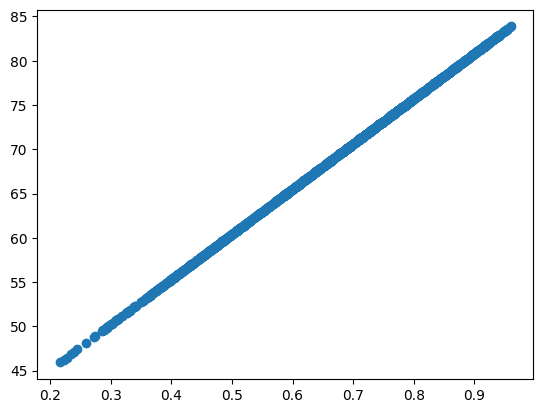

In [5]:
plt.scatter(df_test[HDE], predictions)

Then, we plotted our predictions on top of the scatter plot of the training data. The distribution above and below our line appears to be pretty even, so a linear regression was likely a good choice for this model.

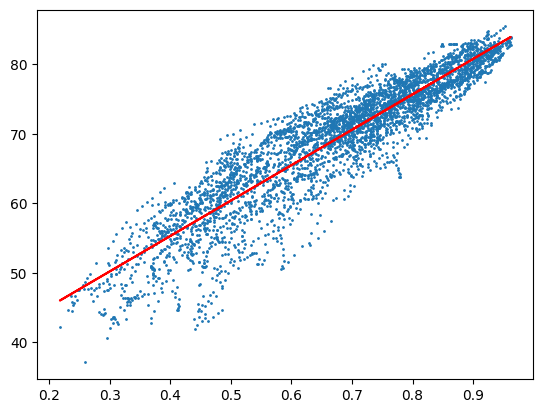

In [6]:
plt.scatter(df_train_hde[HDE], df_train_hde[LEB], s=1)
plt.plot(df_train_hde[HDE], pred, color="red")

We then attempted to find a non-linear model by first finding a variable with a non-linear relationship. We did this by finding the spearman coefficients for each variable, and then finding the variable with the strongest correlation (MA) that didn't seem to have a linear correlation with the pearson test earlier. We transformed the data, and then did a linear regression on it. We found after testing with various monomial degrees that this fit best with a degree 5 monomial.

In [7]:
MA = "Median Age, as of 1 July (years)"

spearman = df_train.corr(method='spearman', min_periods=1, numeric_only=False)
spearman_drop = spearman[LEB].drop(LEB)

# no transform for comparison
df_train_nt_ma = df_train[[MA, LEB]]
linreg_nt_ma = LinearRegression()
linreg_nt_ma.fit(df_train_nt_ma[[MA]], df_train_nt_ma[LEB])
pred_nt_leb = df_train_nt_ma[MA] * linreg_nt_ma.coef_ + linreg_nt_ma.intercept_
correlation_nt_ma = df_train_nt_ma[[MA, LEB]].corr(method='pearson', min_periods=1, numeric_only=False)

# with transform
df_train_ma = df_train[[MA, LEB]]
df_train_ma["LEB Transform"] = (np.pow(df_train_ma[LEB], 5))

df_test_ma = df_test[[MA, LEB]]
df_test_ma["LEB Transform"] = (np.pow(df_test_ma[LEB], 5))

linreg_ma = LinearRegression()
linreg_ma.fit(df_train_ma[[MA]], df_train_ma["LEB Transform"])
pred_leb = df_train_ma[MA] * linreg_ma.coef_ + linreg_ma.intercept_

# for 4: 0.7052068299250327
# for 5: 0.7103432261911896
# for 6: 0.7089855707748298
# for 7: 0.7023901539198063
r2_ma = r2_score(df_train_ma["LEB Transform"], pred_leb)

correlation_ma = df_test_ma[[MA, "LEB Transform"]].corr(method='pearson', min_periods=1, numeric_only=False)

correlation_nt_ma, correlation_ma


C:\Users\hagen\AppData\Local\Temp\ipykernel_4204\1146716693.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train_ma["LEB Transform"] = (np.pow(df_train_ma[LEB], 5))
C:\Users\hagen\AppData\Local\Temp\ipykernel_4204\1146716693.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test_ma["LEB Transform"] = (np.pow(df_test_ma[LEB], 5))


(                                              Median Age, as of 1 July (years)  \
 Median Age, as of 1 July (years)                                      1.000000   
 Life Expectancy at Birth, both sexes (years)                          0.799285   
 
                                               Life Expectancy at Birth, both sexes (years)  
 Median Age, as of 1 July (years)                                                  0.799285  
 Life Expectancy at Birth, both sexes (years)                                      1.000000  ,
                                   Median Age, as of 1 July (years)  \
 Median Age, as of 1 July (years)                          1.000000   
 LEB Transform                                             0.832431   
 
                                   LEB Transform  
 Median Age, as of 1 July (years)       0.832431  
 LEB Transform                          1.000000  )

Our model here is balanced for the most part, but it start to be a little bit lop-sides near x, y = 0

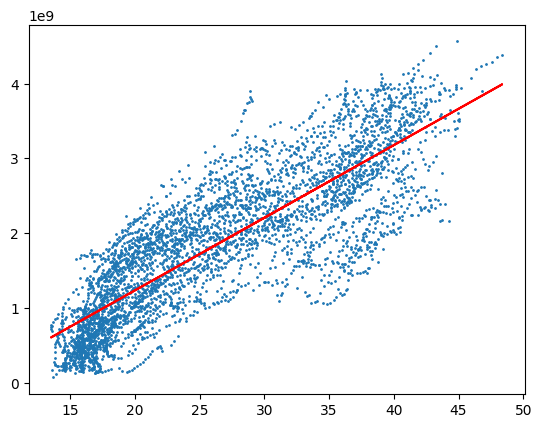

In [8]:
plt.plot(df_train_ma[MA], pred_leb, color="red")
plt.scatter(df_train_ma[MA], df_train_ma["LEB Transform"], s=1)
plt.show()

Here we filled in missing values with the mean value in order to stop some errors preventing us from doing future work.

In [9]:
for feature in variables:
    df_train[feature] = df_train[feature].fillna(value=df_train[feature].dropna().mean())
    df_test[feature] = df_test[feature].fillna(value=df_test[feature].dropna().mean())


Here, we used a set starting with the feature that had the 2nd best pearson correlation coefficient, and looped through all of the features. For each feature, if we got a better MSE on the training set after adding it, we kept it in the set, otherwise we removed it.

In [10]:
s = ["Crude Birth Rate (births per 1,000 population)"]
best_mse = 20

for v in variables:
    if v == "Crude Birth Rate (births per 1,000 population)":
        continue
    if v == HDE or v == LEB:
        continue
    s.append(v)

    ln = LinearRegression()
    ln.fit(df_train[[*s]], df_train[LEB])

    predictions = ln.predict(df_test[[*s]])
    mse = mean_squared_error(df_test[LEB], predictions)
    if mse < best_mse:
        best_mse = mse
    else:
        s.pop()

s, best_mse

(['Crude Birth Rate (births per 1,000 population)',
  'Rate of Natural Change (per 1,000 population)',
  'Population Change (thousands)',
  'Population Growth Rate (percentage)',
  'Population Annual Doubling Time (years)',
  'Births (thousands)',
  'Births by women aged 15 to 19 (thousands)',
  'Total Fertility Rate (live births per woman)',
  'Net Reproduction Rate (surviving daughters per woman)',
  'Mean Age Childbearing (years)',
  'Sex Ratio at Birth (males per 100 female births)',
  'Total Deaths (thousands)',
  'Crude Death Rate (deaths per 1,000 population)',
  'Live births Surviving to Age 1 (thousands)',
  'Net Number of Migrants (thousands)',
  'Net Migration Rate (per 1,000 population)'],
 np.float64(8.741667438088301))

The initial list of features that was created is everything listed below. We took that list, and removed features that we believed were similar to other ones already present in the list. Then, we took the remaining items in the list, found their pearson correlation coefficient from earlier, and removed all remaining items with a coeffecient with a magnitude less than 0.5.

In [11]:
newvars = [
    'Crude Birth Rate (births per 1,000 population)',           # -0.86
    # 'Rate of Natural Change (per 1,000 population)',
    # 'Population Change (thousands)',
    # 'Population Growth Rate (percentage)',                    # -0.2853
    # 'Population Annual Doubling Time (years)',
    # 'Births (thousands)',
    # 'Births by women aged 15 to 19 (thousands)',
    'Total Fertility Rate (live births per woman)',             # -0.83
    'Net Reproduction Rate (surviving daughters per woman)',    # -0.78
    # 'Mean Age Childbearing (years)', # 0.0423
    # 'Sex Ratio at Birth (males per 100 female births)',       # 0.407
    # 'Total Deaths (thousands)',
    'Crude Death Rate (deaths per 1,000 population)',           # -0.54
    # 'Live births Surviving to Age 1 (thousands)',
    # 'Net Number of Migrants (thousands)',
    # 'Net Migration Rate (per 1,000 population)'               # 0.13
]

In [15]:

ln = LinearRegression()
ln.fit(df_train[[*newvars]], df_train[LEB])

predictions = ln.predict(df_test[[*newvars]])
mse = mean_squared_error(df_test[LEB], predictions)
r2 = r2_score(df_test[LEB], predictions)

df_test2 = pd.DataFrame({"leb": df_test[LEB], "pred": predictions})
pearson = df_test2.corr(method='pearson', min_periods=1, numeric_only=False)

mse, r2, ln.intercept_, ln.coef_, pearson

(np.float64(9.267060571891506),
 0.8947807088854511,
 np.float64(90.86105544848053),
 array([-1.36076142,  2.76541074,  6.98149005, -0.95305455]),
            leb      pred
 leb   1.000000  0.945992
 pred  0.945992  1.000000)

With 4 variables we were able to out-perform our model from earlier that used just the Human Development Index.